In [9]:
import numpy as np
from math import log10, ceil, floor
from functools import partial
from itertools import product
import matplotlib.pyplot as plt

## 1. Spreading

In [51]:
def compute_w(epsilon):
    return ceil(log10(1/epsilon)) + 1
    
def compute_beta(epsilon):
    return 2.3 * compute_w(epsilon)

def fine_grid_size(nonuniform_grid_size, w, upsampling_factor=2):
    # TODO fix
    sz = np.ceil(np.maximum(upsampling_factor * nonuniform_grid_size, 2*w*np.ones_like(nonuniform_grid_size)))
    return sz.astype(int)

def fine_grid_spacing(n):
    return 2*np.pi / n

def kernel(z, beta):
    return np.exp(beta * (np.sqrt(1 - z*z) - 1)) if abs(z) <= 1 else 0

def compute_alpha(w, n):
    return w * np.pi / n

# grid of elements of Z (signed integers) such that the kernel function is not zero
# on xi - 2 pi mi, i = 0,...,d where d is the number of dimensions
def m_grid(point, alpha):
    xi = point[0]
    alpha_i = alpha[0]
    return tuple(
        tuple(range(ceil((xi - alpha_i)/(2*np.pi)), floor((xi + alpha_i)/(2*np.pi)) + 1)) 
            for xi, alpha_i in zip(point, alpha)
    ) 

In [78]:
# all the points in R^d where we evaluate the function
pts = np.reshape(np.meshgrid([0.1 * i for i in range(11)], [0.1 * (i*i) for i in range(16)]),(2,-1)).T
N = np.array([len(np.unique(pts[:,i])) for i in range(pts.shape[1])])

epsilon = 1.e-10

w = compute_w(epsilon)
beta = compute_beta(epsilon)
n = fine_grid_size(N, w)
h = fine_grid_spacing(n)
krn = partial(kernel, beta=beta)
alpha = compute_alpha(w,n)

print('w = {}, beta = {}'.format(w, beta))
print('N (non-uniform grid) = {}, n (uniform grid) = {}'.format(N, n))
print('h (fine grid spacing) = {}'.format(h))
print('alpha = {}'.format(alpha))

w = 11, beta = 25.299999999999997
N (non-uniform grid) = [11 16], n (uniform grid) = [22 32]
h (fine grid spacing) = [0.28559933 0.19634954]
alpha = [1.57079633 1.07992247]


In [79]:
def psi(x, alpha, kernel):
    krn = np.frompyfunc(kernel, 1, 1)
    return np.prod(krn(np.divide(x, alpha)))

# takes a point xi in input and the set of integers that make the
# |(xi - 2 pi m_i) / alpha_i| <= 1
# prt_psi accepts only a vector of coords
def psi_per(xi, prt_psi, alpha, verbose=False):
    # apply psi to a given combination of m1,..,md
    compute_psi = lambda ms: prt_psi(*(xi - 2*np.pi*ms))
    
    mi = m_grid(xi, alpha)
    # assert all(ms for ms in mi)
    if not all(mi):
        if verbose:
            print('[WARNING] no m found for x={}'.format(xi))
        return 0
    
    return sum(map(compute_psi, map(np.array, product(mi))))

In [84]:
# l is a vector of fine grid indexes
# f is the vector of values of the function
#    in all the points (i.e. rows) of the matrix x
# x is a matrix whose rows are coordinates in which the function
#    is evaluated
# h is the spacing in the uniform grid
def compute_b(l, f, points, h, prt_psi_per):    
    sm = 0
    lh = np.multiply(l, h)
    for fi, xi in zip(f,points):
        sm += fi * prt_psi_per(lh - xi)
    return sm

In [86]:
prt_psi = partial(psi, alpha=alpha, kernel=partial(kernel, beta=beta))

f = np.array([i for i in range(len(x))])
l = np.array([1,1])
prt_psi_per = partial(psi_per, prt_psi=prt_psi, alpha=alpha)

compute_b(l, f=f, points=pts, h=h, prt_psi_per=prt_psi_per)

1.0988069577065676

## 2. FFT

In [95]:
prt_compute_b = partial(compute_b, f=f, points=pts, h=h, prt_psi_per=prt_psi_per)
b = np.zeros(n, dtype=float)

# TODO improve performance
for cmb in map(tuple, product(*(range(ni) for ni in n))):
    b[cmb] = prt_compute_b(cmb)

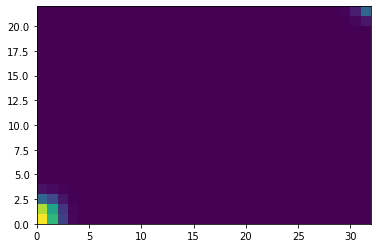

In [98]:
plt.pcolormesh(b);

In [99]:
fftb = np.fft.fftn(b)

## Deconvolution

In [100]:
# translation is a vector containing the original shape of the FFT
# which is used to translate back the indexes
def correction_factor(frq_indexes, translation, w, kernel, alpha):
    vec_krn = np.vectorize(kernel)
    frq_indexes -= translation / 2
    return (2/w)*(2/w) / (np.prod(vec_krn(np.multiply(alpha, frq_indexes))))

In [102]:
prt_correction_factor = partial(correction_factor, translation=np.array(fftb.shape), w=w, 
                                kernel=partial(kernel, beta=beta), alpha=alpha)

N_frq = np.array([10,6])
p = np.zeros(N_frq, dtype=float)

for cmb in product(*(range(ni) for ni in N_frq)):
    p[cmb] = prt_correction_factor(cmb)

<ipython-input-100-099da2abf43f>:6: RuntimeWarning: divide by zero encountered in true_divide
  return (2/w)*(2/w) / (np.prod(vec_krn(np.multiply(alpha, frq_indexes))))


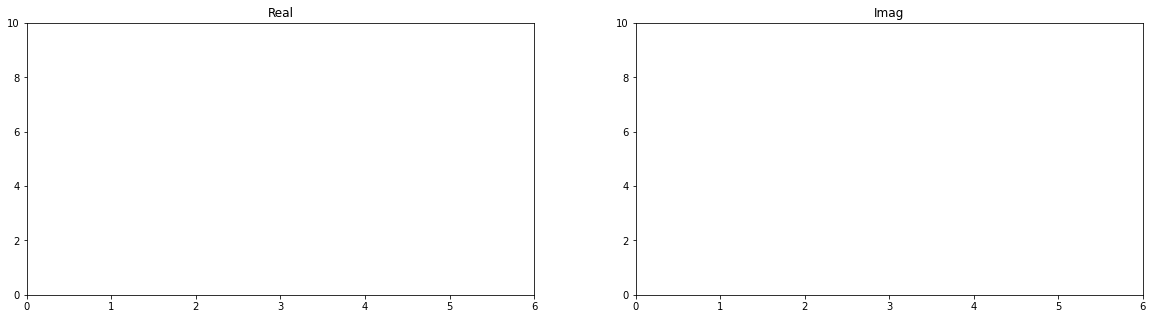

In [108]:
# assume this is all always even
def extract_center(shape, n):
    return tuple(slice(shape[i]//2 - n[i]//2, shape[i]//2 + n[i]//2) for i in range(len(n)))

cropped_fftb = fftb[extract_center(fftb.shape, N_frq)]
ftilde = np.multiply(p, cropped_fftb)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.pcolormesh(ftilde.real)
plt.title('Real')
plt.subplot(1,2,2)
plt.pcolormesh(ftilde.imag)
plt.title('Imag')
plt.show()